# Caso juguete

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.widgets import Slider
from scipy.ndimage import gaussian_filter
from scipy import sparse

In [2]:
H = 1e3
N = 46
xs, ys = np.meshgrid( np.linspace(-1,1,N), np.linspace(-1,1,N) )
X = np.concatenate( [ xs.flatten()[...,None], ys.flatten()[...,None] ] , axis=1)

In [3]:
R = 0.7
fX = np.linalg.norm( X, axis=1 ) - R
dfX = X / np.linalg.norm( X, axis=1 )[...,None]
LfX = np.clip( -10, 10 ,2 / np.linalg.norm( X, axis=1 )[...,None] )
#u0 = gaussian_filter( np.eye( 1,N**2, k=( np.arange(0, N**2)[fX < 1e-5] )[0] ).reshape((N,N)), 1.5 ).flatten()
u0 = np.eye( 1,N**2, k=( np.arange(0, N**2)[fX < 1e-5] )[0] ) * H

In [ ]:
fig, axs = plt.subplots(1, 2, figsize=(10, 5))

axs[0].scatter(X[:,0], X[:,1], c=np.clip(-1,1,fX), cmap='bwr')
axs[1].scatter(X[:,0], X[:,1], c=LfX, cmap='viridis')

axs[0].set_title(r'$f(\vec{x})$')
axs[1].set_title(r'$\Delta f(\vec{x})$')

plt.tight_layout()
plt.show()

In [89]:
L = sparse.csr_matrix((N**2, N**2))
ones = np.ones(N**2)
L.setdiag( ones * - 4, k=0)
decoupled_ones = ones - (np.arange(1,N**2 + 1) % N == 0)
L.setdiag( decoupled_ones, k=1 )
L.setdiag( decoupled_ones, k=-1)

L.setdiag( ones, k=-N)
L.setdiag( ones, k=N)

h = 2 / (N-1)

L *= 1 / (h ** 2)

Gx = sparse.csr_matrix( (N**2, N**2) )
Gx.setdiag( ones * (-1), k=0)
Gx.setdiag( decoupled_ones, k=1)
Gx *= (1 / h)
Dpsix = sparse.csr_matrix( (N**2, N**2) )
Dpsix.setdiag( dfX[:,0], k=0)

Gy = sparse.csr_matrix( (N**2, N**2) )
Gy.setdiag( ones * (-1), k=0)
Gy.setdiag( ones, k=N)
Gy *= (1 / h)
Dpsiy = sparse.csr_matrix( (N**2, N**2) )
Dpsiy.setdiag( dfX[:,1], k=0)

DLpsi = sparse.csr_matrix( (N**2, N**2) )
DLpsi.setdiag( LfX.flatten(), k=0)

G = DLpsi @ (Dpsix @ Gx + Dpsiy @ Gy)

I = sparse.csr_matrix( (N**2, N**2) )
I.setdiag( ones, k=0 )

In [101]:
timesteps = 1000
t = (h ** 2) / 4
print(t)
ut = [ u0.flatten() ]

for _ in range(timesteps):
    ut.append( sparse.linalg.spsolve( (I - t * (L - G)), ut[-1]) )

In [ ]:
i = 1
fig, axs = plt.subplots(1, 2, figsize=(10, 5))
axs[0].scatter(X[:,0], X[:,1], c=u0, vmin=0, vmax=1, cmap='viridis')
axs[1].scatter(X[:,0], X[:,1], c=ut[i], vmin=0, vmax=1, cmap='viridis')

axs[0].set_title(r'$u(0)$')
axs[1].set_title(r'$u(t)$')

plt.tight_layout()
plt.show()

# SIREN

In [21]:
import torch
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.animation as animation
from src.model import SIREN
from src.laplacian import gridLaplacian, gridGradProyection, sdfLaplacian, gridLaplacianOld
from scipy import sparse
from scipy.ndimage import gaussian_filter
from src.diff_operators import gradient, divergence

In [3]:
def evaluate( model, samples, max_batch=64**2, device=torch.device(0) ):
    # samples = ( amount_samples, 3 )    
    head = 0
    amount_samples = samples.shape[0]

    evaluations = np.zeros( (amount_samples, 1))
    gradients = np.zeros( (amount_samples, 2))
    #hessians = np.zeros( (amount_samples, 2, 2))
    laplacians = np.zeros( (amount_samples, 1))

    while head < amount_samples:        
        if torch.is_tensor(samples):
            inputs_subset = samples[head:min(head + max_batch, amount_samples), :]
        else:

            inputs_subset = torch.from_numpy(samples[head:min(head + max_batch, amount_samples), :]).float()
            
        inputs_subset = inputs_subset.to(device).unsqueeze(0)

        x, y =  model(inputs_subset).values()
        subset_grad = gradient(y,x)
        gradients[head:min(head + max_batch, amount_samples)] = subset_grad.squeeze(0).detach().cpu().numpy()[..., :]
        #hessians[head:min(head + max_batch, amount_samples)] = jacobian( subset_grad, x ).squeeze(0).detach().cpu().numpy()[..., :]
        laplacians[head:min(head + max_batch, amount_samples)] = divergence( subset_grad, x ).squeeze(0).detach().cpu().numpy()[..., :]
        evaluations[head:min(head + max_batch, amount_samples)] = y.squeeze(0).detach().cpu()
        head += max_batch

    return evaluations, gradients, laplacians

In [4]:
model = SIREN(
        n_in_features= 2,
        n_out_features=1,
        hidden_layer_config=[64]*6,
        w0=30,
        ww=None,
        activation= 'sine'
)
model.load_state_dict( torch.load('results/bezier/experiment/models/model_best.pth', weights_only=True))

device = torch.device(1)
model.to(device)

SIREN(
  (net): Sequential(
    (0): Sequential(
      (0): Linear(in_features=2, out_features=64, bias=True)
      (1): SineLayer(w0=30)
    )
    (1): Sequential(
      (0): Linear(in_features=64, out_features=64, bias=True)
      (1): SineLayer(w0=30)
    )
    (2): Sequential(
      (0): Linear(in_features=64, out_features=64, bias=True)
      (1): SineLayer(w0=30)
    )
    (3): Sequential(
      (0): Linear(in_features=64, out_features=64, bias=True)
      (1): SineLayer(w0=30)
    )
    (4): Sequential(
      (0): Linear(in_features=64, out_features=64, bias=True)
      (1): SineLayer(w0=30)
    )
    (5): Sequential(
      (0): Linear(in_features=64, out_features=64, bias=True)
      (1): SineLayer(w0=30)
    )
    (6): Sequential(
      (0): Linear(in_features=64, out_features=1, bias=True)
    )
  )
)

In [5]:
N = 64
xs, ys = np.meshgrid( np.linspace(-1,1,N), np.linspace(-1,1,N) )
X = np.concatenate( [ xs.flatten()[...,None], ys.flatten()[...,None] ] , axis=1)

In [6]:
fX, dfX, LfX = evaluate(  model, X, device=device )
LfX = np.clip( LfX, np.percentile(LfX, 0.1), np.percentile(LfX, 99.9))
u0 = np.eye( 1,N**2, k=( np.arange(0, N**2)[fX.flatten() < 1e-8] )[550] )
#u0 = gaussian_filter( np.eye( 1,N**2, k=( np.arange(0, N**2)[fX.flatten() < 1e-8] )[100] ).reshape((N,N)), 1.5 ).flatten()

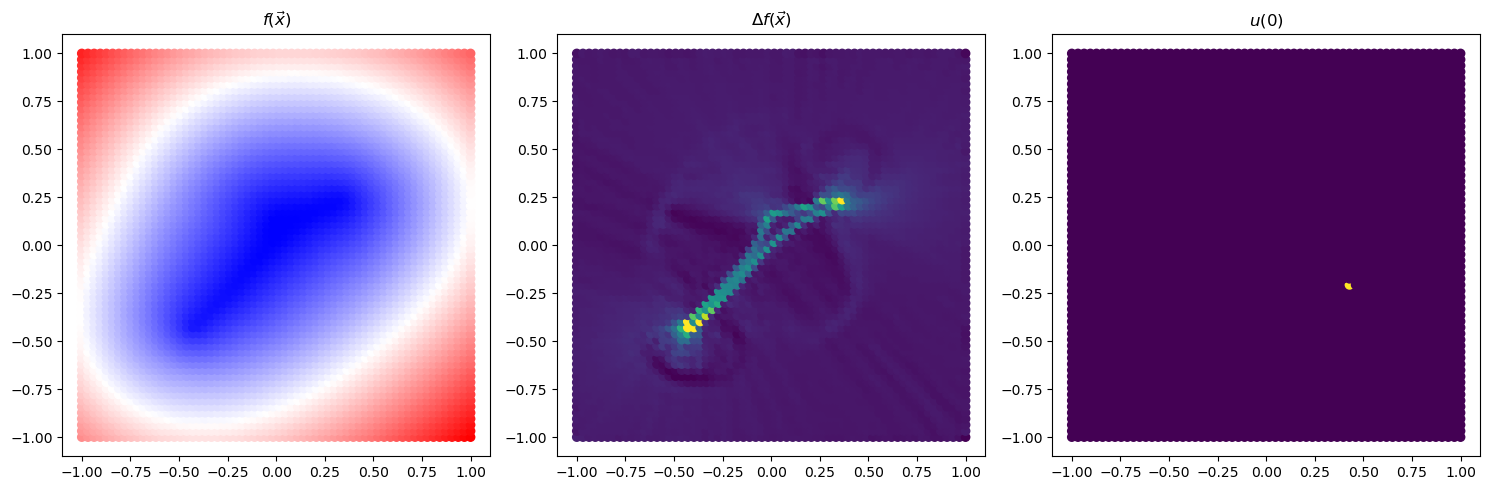

In [7]:
fig, axs = plt.subplots(1, 3, figsize=(15, 5))

axs[0].scatter(X[:,0], X[:,1], c=np.clip(-1,1,fX), cmap='bwr')
axs[1].scatter(X[:,0], X[:,1], c=LfX, cmap='viridis')
axs[2].scatter(X[:,0], X[:,1], c=u0, cmap='viridis')

axs[0].set_title(r'$f(\vec{x})$')
axs[1].set_title(r'$\Delta f(\vec{x})$')
axs[2].set_title(r'$u(0)$')

plt.tight_layout()
plt.show()

Queremos resolver el sistema:
$$(I - tL_{\partial \psi}) u_t = u_0 $$

Donde $L_{\partial \psi}$ es el operador matricial discreto de $\Delta_{\partial \psi}u = \Delta u - (\nabla u \cdot \nabla \psi) \Delta \psi$.
$$L_{\partial \psi} u \rightarrow (L - G) \vec{u}$$

Definimos:
1. $ L = \frac{1}{h^2}\begin{pmatrix} -4 & 1 & \dots & 0& 1 & \dots \\ 1 & -4 & 1 & \dots & 0 & 1\dots \\ &  & \dots &  &  &  \\ &  &  &  &  &  \\ \end{pmatrix} $

2. $  G = \frac{1}{2h} \begin{pmatrix} 0 & \psi_x \Delta \psi & \dots & 0 & \psi_y \Delta \psi & \dots \\ -\psi_x \Delta \psi & 0 & \psi_x \Delta \psi & \dots & 0 & \psi_y \Delta \psi \dots \\  &  & \dots &  &  &  \\ \end{pmatrix} $

En el caso de la $G$ notar que cada $\psi_x, \psi_y, \nabla \psi$ esta evaluado en $u_i$ correspondiente a la fila.

In [34]:
#L = gridLaplacian( N, np.abs(fX.flatten()) < 0.15 )
#G = gridGradProyection( N, dfX, LfX, np.abs(fX.flatten()) < 0.15 )# np.inf )

#L = sdfLaplacian( N ,X,fX, dfX, LfX)
L = gridLaplacianOld(N )

In [35]:
timesteps = 300
h = 2 / (N-1)
t = 2 * (h ** 2) 
print(t)
ut = [ u0.flatten() ]

I = sparse.csr_matrix( (N**2, N**2) )
I.setdiag( np.ones(N ** 2), k=0 )
for _ in range(timesteps):
    # Backward-Euler
    ut.append( sparse.linalg.spsolve( (I - t * ( L)), ut[-1]) )
    #ut.append( sparse.linalg.spsolve( (I - t * ( L - G)), ut[-1]) )

    # Forward-Euler
    #ut.append( ut[-1] + t * (L-G) @ ut[-1])

    # RK4
    #k1 = (L - G) @ ut[-1]
    #k2 = (L - G) @ (ut[-1] + 0.5 * t * k1)
    #k3 = (L - G) @ (ut[-1] + 0.5 * t * k2)
    #k4 = (L - G) @ (ut[-1] + t * k3)
    #ut.append( ut[-1] + (t/6) * (k1 + 2*k2 + 2*k3 + k4) )

0.0020156210632401106


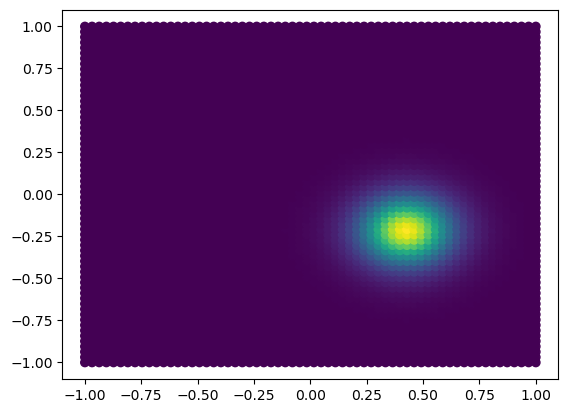

In [36]:
i = 6
plt.scatter(X[:, 0], X[:, 1], c=ut[i], vmin=0,vmax= np.max(ut[i]), cmap='viridis')

Creating animation
Saving animation


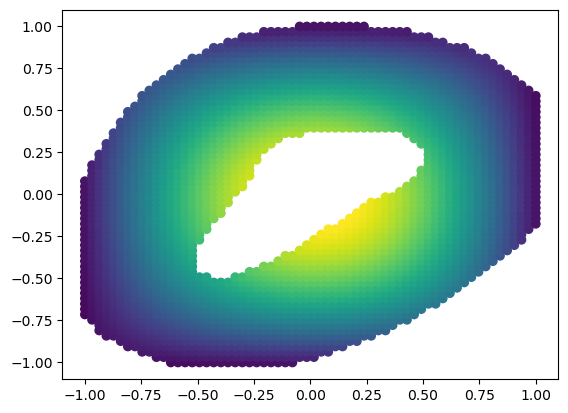

In [37]:
fig, ax = plt.subplots()
mask = np.abs(fX.flatten()) < 0.3
scat = ax.scatter(X[mask, 0], X[mask, 1], c=ut[0][mask], vmin=0,vmax= np.max(ut[0][mask]), cmap='viridis')

def animate(i):
    scat.set_array(ut[i][mask])  # Update the scatter plot with the new u_t values
    scat.set_clim( vmin=0, vmax= np.max(ut[i][mask]))
    return scat

print("Creating animation")
ani = animation.FuncAnimation(fig, animate, repeat=True,
                                    frames=len(ut) - 1, interval=5)

print("Saving animation")
writer = animation.PillowWriter(fps=32,
                                metadata=dict(artist='Me'),
                                bitrate=450)
ani.save('scatter_OG_HD_big.gif', writer=writer)

plt.show()

In [11]:
from PIL import Image
norm = lambda x : ( x - np.min(x) ) / np.max( x - np.min(x) )
frames = [
    Image.fromarray(( norm(ut[i]).reshape((N,N)) * 255).astype(np.uint8))
    for i in range(len(ut))
]
frames[0].save(
    "bezier.gif", 
    format="GIF",
    append_images=frames,
    save_all=True, 
    duration=10, 
    loop=1
)